In [10]:
import numpy as np
from pandas import DataFrame
import skimage.io as io
from skimage.transform import resize
from skimage.measure import label, regionprops, marching_cubes_lewiner, mesh_surface_area
from skimage.draw import ellipse
from skimage import img_as_ubyte, img_as_bool
from scipy.ndimage.morphology import binary_erosion, distance_transform_edt, binary_fill_holes
from skimage.util import invert
from tqdm.notebook import tqdm
import joblib
import time
import os
import glob
import skfmm

def Erosion3DimJ(input_img):
    tmp = np.zeros(input_img.shape, dtype=np.bool)
    for i in range(input_img.shape[0]):
        tmp[i, :, :] = binary_erosion(input_img[i, :, :])
    return tmp

# Find the 3D bounding box
def bbox2_3D(img, value):
    # From https://stackoverflow.com/questions/31400769/bounding-box-of-numpy-array
    z = np.any(img == value, axis=(1, 2))
    c = np.any(img == value, axis=(0, 2))
    r = np.any(img == value, axis=(0, 1))
    zmin, zmax = np.where(z)[0][[0, -1]]
    cmin, cmax = np.where(c)[0][[0, -1]]
    rmin, rmax = np.where(r)[0][[0, -1]]
    return rmin, rmax, cmin, cmax, zmin, zmax

def Threshold(input_img, Th_value):
    tmp = np.zeros(input_img.shape, dtype=np.bool)
    if isinstance(Th_value, int):
        tmp[input_img == Th_value] = 1
    else:
        if isinstance(Th_value, float):
            tmp[input_img > 0. & input_img < 1.] = 1
        else:
            for th_val in range(len(Th_value)):
                tmp[input_img == Th_value[th_val]] = 1
    return tmp

# Define some parameters/variables
CHL = 3
MIT = 4
VAC = 2
CELL = 1
AIR = 5
ADJ = 6

# Voxel shape
voxel_dims = [0.05,0.02,0.02] #um
voxel_ratio = voxel_dims[0]/voxel_dims[1]
voxel_iso_dims = [0.05,0.05,0.05] #um

[0 2 3 4 5 6]
(551, 804, 824)


/home/guillaume/miniconda3/envs/3D-random-walker/lib/python3.8/site-packages/skimage/io/_plugins/matplotlib_plugin.py:150: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


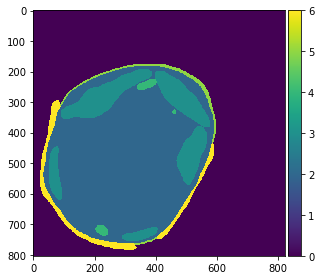

In [2]:
# Load image
cell_img = img_as_ubyte(io.imread('/home/guillaume/Downloads/RHarwood-cell/D2C2/D2C2_merged-cropped.tif'))
print(np.unique(cell_img))
print(cell_img.shape)
io.imshow(cell_img[200])

In [3]:
# Create isotropic image
print('Current anisotropic shape:', cell_img.shape)
print('New isotropic shape: ',(int(cell_img.shape[0]*voxel_ratio), cell_img.shape[1], cell_img.shape[2]))
cell_iso = np.zeros((int(cell_img.shape[0]*voxel_ratio), cell_img.shape[1], cell_img.shape[2]), dtype='uint8')

# Resize cropped image to have isotropic voxels
for i in range(cell_img.shape[1]):
    cell_iso[:,i,:] = resize(cell_img[:,i,:], output_shape=(int(cell_img.shape[0]*voxel_ratio), cell_img.shape[2]),
                             anti_aliasing=False, preserve_range=True, order=0)


Current anisotropic shape: (551, 804, 824)
New isotropic shape:  (1377, 804, 824)


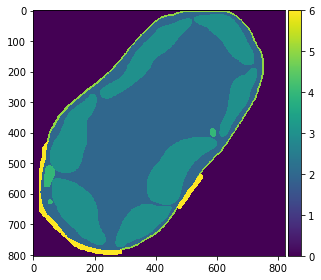

In [4]:
io.imshow(cell_iso[200])

In [5]:
## Extract the stacks for the surface to compute
# Mitochondria
mito_stack = (cell_iso == MIT)
mito_erosion = Erosion3DimJ(mito_stack)
mito_edge = mito_stack ^ mito_erosion
mito_pos = np.argwhere(mito_edge)
del mito_erosion
print(mito_pos.shape)

# Chloroplasts
chl_stack = (cell_iso == CHL)
chl_erosion = Erosion3DimJ(chl_stack)
chl_edge = chl_stack ^ chl_erosion
chl_pos = np.argwhere(chl_edge)
del chl_erosion
print(chl_pos.shape)

# Chl + Mito stack
chl_mito = mito_stack + chl_stack

(389894, 3)
(2777129, 3)


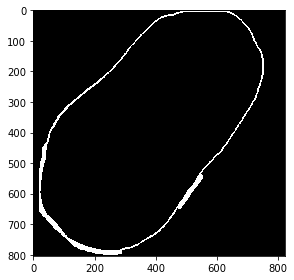

In [6]:
# All CW
all_cw_stack = Threshold(cell_iso, (AIR, ADJ))
io.imshow(all_cw_stack[200])

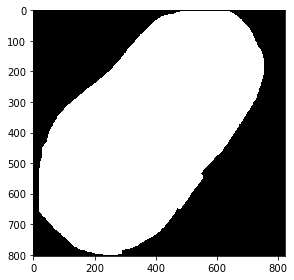

In [15]:
# Vacuole stack
vac_stack = binary_fill_holes(invert((cell_iso == 0)) + all_cw_stack)
io.imshow(vac_stack[200])

/home/guillaume/miniconda3/envs/3D-random-walker/lib/python3.8/site-packages/skimage/io/_plugins/matplotlib_plugin.py:150: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


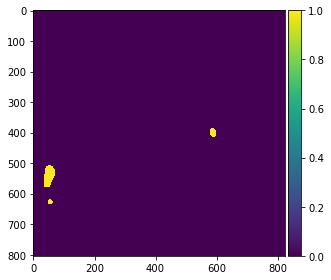

In [16]:
io.imshow(mito_stack[200])

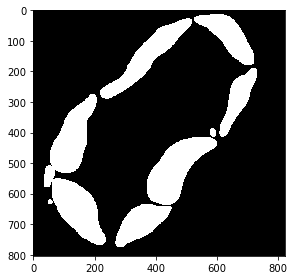

In [17]:
io.imshow(chl_mito[200])

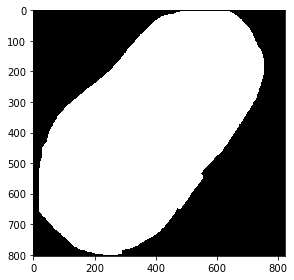

In [18]:
io.imshow(vac_stack[200])

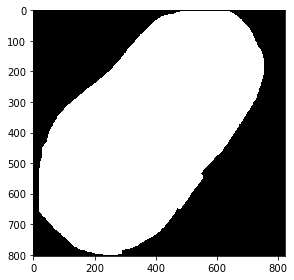

In [19]:
# Create masked array
air_masked_array = np.ma.masked_array(vac_stack, chl_mito)
io.imshow(air_masked_array[200])

In [20]:
# compute geodesic distance
t0 = time.time()
D_geo = skfmm.distance(air_masked_array, dx=voxel_iso_dims)
print('D_geo processing time:',str(np.round((time.time()-t0), 1)),'s')

D_geo processing time: 952.7 s


(1377, 804, 824)
float64


/home/guillaume/miniconda3/envs/3D-random-walker/lib/python3.8/site-packages/skimage/io/_plugins/matplotlib_plugin.py:150: UserWarning: Float image out of standard range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


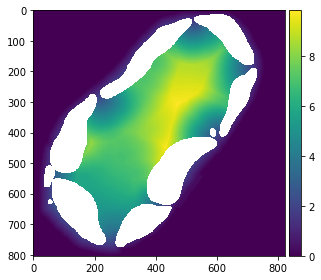

In [21]:
print(D_geo.shape)
print(D_geo.dtype)
io.imshow(D_geo[200])

In [22]:
# Compute Euclidean distance
t0 = time.time()
D_euc = np.ma.masked_array(distance_transform_edt(vac_stack, sampling=voxel_iso_dims), chl_mito, dtype="float32")
print('D_euc processing time:',str(np.round((time.time()-t0), 1)),'s')

D_euc processing time: 349.6 s


(1377, 804, 824)
float32


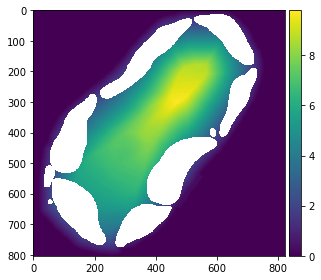

In [23]:
print(D_euc.shape)
print(D_euc.dtype)
io.imshow(D_euc[200])

In [29]:
# Create dictionnary and DataFrame of results
results_mit = {'L_geo': np.asarray(D_geo[mito_edge]),
               'L_euc': np.asarray(D_euc[mito_edge])}
results_mit_df = DataFrame(results_mit)

In [ ]:
# Create dictionnary and DataFrame of results
results_chl = {'L_geo': np.asarray(D_geo[chl_edge]),
               'L_euc': np.asarray(D_euc[chl_edge])}
results_chl_df = DataFrame(results_chl)

In [27]:
## NOT EDITED

# Export results to text file
results_mit_df.to_csv('/home/guillaume/Downloads/RHarwood-cell/'+sample_name+'/rw_results/'+sample_name+'_random_walk_for_all_mit-'+str(j)+'.txt', sep='\t', encoding='utf-8')

# Create dictionnary and DataFrame of results
results_mit = {'L_geo': np.asarray(D_geo[mito_edge]),
               'L_euc': np.asarray(D_euc[mito_edge])}
results_mit_df = DataFrame(results)
# Export results to text file
results_mit_df.to_csv('/home/guillaume/Downloads/RHarwood-cell/'+sample_name+'/rw_results/'+sample_name+'_random_walk_for_all_mit-'+str(j)+'.txt', sep='\t', encoding='utf-8')

True